In [1]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import os,sys

modelNames = ['ZScorePredictor','FiveDayPredictor','TmmrwUpPredictor']
verbose = False
secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
sectorFolder = 'data/by_sector'
catLabels = ['ticker','industry']
trainDir = 'trainData/'

In [2]:
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    if verbose:
        myMatrix = plot_confusion_matrix(predictor, attributes, labels,
                                     cmap=plt.cm.Blues, normalize = 'all')    
        plt.show()
    return  errorScore/len(predicted)

In [3]:
def catBoostMaker(df,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, count, toSave, sector):
    catIndicies = []
    counter = -1
    for col in df.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.append(counter)
    masterList = df.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList, tmmrwUpTrainList, tmmrwUpTestList = \
    train_test_split(masterList, zScoreAnswer, fiveDayChangeAnswer, tmmrwUpAnswer, test_size = .25)
    
    answerTrainList = [zScoreTrainList,fiveDayChangeTrainList, tmmrwUpTrainList]
    answerTestList = [zScoreTestList,fiveDayChangeTestList, tmmrwUpTestList]
    trainPools = [Pool(data = masterTrainList, label = x, cat_features = catIndicies) for x in answerTrainList]
    testPools = [Pool(data = masterTestList, label = x, cat_features = catIndicies) for x in answerTestList]
    
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    featureDF = pd.DataFrame(data = 
                         {'featureName': [col for col in df.columns],
                        'importance': [0] * len([col for col in df.columns])}).set_index('featureName')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in df.columns])
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli', iterations = 150, 
                                   train_dir = '{}{}_{}'.format(trainDir, sector, count))
        model.fit(train, eval_set = test, logging_level = 'Silent')
        if toSave:
            sectorFolder = '{}{}'.format(folderRoot, sector)
            if not os.path.exists(sectorFolder):
                os.makedirs(sectorFolder)
            model.save_model('{}/{}-{}.cbm'.format(sectorFolder, name, count))
        accuracy =  model.score(test)
        error = scoreCalculator(model, test,test.get_label())
        accuracyList.append(accuracy)
        scoreList.append(error)
        featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)
        featureDFPart = pd.DataFrame(data = 
                     {'featureName': featureList['Feature Id'],
                    'importance': featureList['Importances']}).set_index('featureName')
        featureDF = featureDF + featureDFPart
        if verbose:
            print(name)
            print('Accuracy: ', accuracy)
            print('Error Score:', error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)
    return averageAccuracy, averageScore, featureDF

In [4]:
#returns feature to remove, mean error score, # of significant (non answer or date) columns
def buildForest(file, droppedColumns, toSave):
    sector = file.split('.')[0]
    sector = sector.replace(' ', '-')
    file = sectorFolder + '/' + file
    secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
    catAccuracy = []
    catError = []
    masterFeatureDF = None
    colCount = 0
    combinedDF = None
    if os.stat(file).st_size > 2000000:
        chunks = pd.read_csv(file, parse_dates = True, chunksize = 150000)
        for idx, chunk in enumerate(chunks):
            chunk.drop(columns = ['Date'], inplace = True)
            zScoreAnswer = chunk['zScoreOfChangeTmmrw']
            zScoreAnswer = zScoreAnswer.astype('float')
            zScoreAnswer = ['long' if x > 0 else 'short' for x in zScoreAnswer]
            fiveDayChangeAnswer = chunk['percentChangeInFiveDays']
            fiveDayChangeAnswer = ['long' if x > 0 else 'short' for x in fiveDayChangeAnswer]
            tmmrwUpAnswer = chunk['tmmrwChngAsPerc']
            tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

            chunk.drop(columns = secretColumns, inplace = True)
            accuracy, error, featureDF = \
            catBoostMaker(chunk,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, idx, toSave, sector)
            catAccuracy.append(accuracy)
            catError.append(error)
            if idx == 0:
                masterFeatureDF = featureDF
            else:
                masterFeatureDF = masterFeatureDF + featureDF
            break


    else :
        combinedDF = pd.read_csv(file, parse_dates = True)
        combinedDF.drop(columns = ['Date'], inplace = True)
        zScoreAnswer = combinedDF['zScoreOfChangeTmmrw']
        zScoreAnswer = zScoreAnswer.astype('float')
        zScoreAnswer = ['long' if x > 0 else 'short' for x in zScoreAnswer]
        fiveDayChangeAnswer = combinedDF['percentChangeInFiveDays']
        fiveDayChangeAnswer = ['long' if x > 0 else 'short' for x in fiveDayChangeAnswer]
        tmmrwUpAnswer = combinedDF['tmmrwChngAsPerc']
        tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

        combinedDF.drop(columns = secretColumns, inplace = True)
        accuracy, error, featureDF = \
        catBoostMaker(chunk,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, catLabels, idx, toSave, sector)
        catAccuracy.append(accuracy)
        catError.append(error)
        masterFeatureDF = featureDF
    
    if verbose:
        print('-------------------------------------------\n\n')
        print('Final Catboost accuracy: ', mean(catAccuracy))
        print('Final Catboost score: ' ,mean(catError))
        print('Final Feature Importance:', masterFeatureDF.sort_values(by = ['importance']))
    lowestImportance = masterFeatureDF['importance'].min()
    minValues = masterFeatureDF[masterFeatureDF['importance'] == lowestImportance]
    toRemove = minValues.index.values.tolist()
    if verbose:
        print(type(toRemove))
        print('Feature to remove: ', toRemove)
    return toRemove, mean(catError), colCount, masterFeatureDF

Basic-Materials
droppedColumns: []
valuesToTry: []
droppedColumns: ['DPRIMEValue']
valuesToTry: ['DPRIMElastChangeP', 'PRS85006092bPercent']
change in score by removing DPRIMEValue is 0.004311111111109156
droppedColumns: ['DPRIMEValue', 'DPRIMElastChangeP']
valuesToTry: ['PRS85006092bPercent']
change in score by removing DPRIMElastChangeP is -0.030755555555554537
droppedColumns: ['DPRIMEValue', 'PRS85006092bPercent']
valuesToTry: []
change in score by removing PRS85006092bPercent is -0.03271111111111136
Final dropped columns: ['DPRIMEValue']


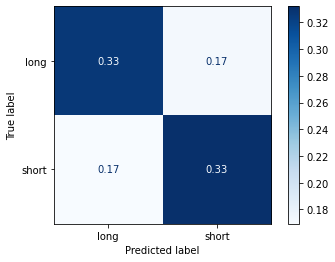

ZScorePredictor
Accuracy:  0.6582133333333333
Error Score: 7.174933333333334


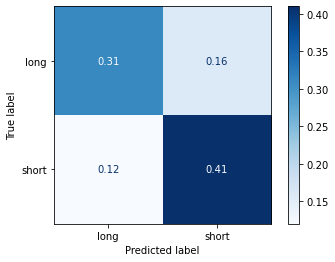

FiveDayPredictor
Accuracy:  0.7216
Error Score: 9.462666666666667


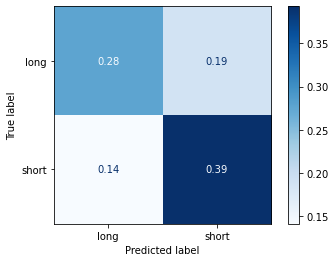

TmmrwUpPredictor
Accuracy:  0.6704533333333333
Error Score: 7.5254666666666665
-------------------------------------------


Final Catboost accuracy:  0.6834222222222222
Final Catboost score:  8.054355555555555
Final Feature Importance:                        importance
featureName                      
WPU0911Value             0.000000
DPRIMElastChangeP        0.000000
DPRIMEValue              0.000000
CONSUMERValue            0.000000
PRS85006092bPercent      0.000000
...                           ...
DTWEXAFEGSlastChangeP    5.483356
DEXUSUKlastChangeP       6.153721
industry                 6.409651
typPrice                 8.282367
aroon                   11.282433

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CONSUMERValue', 'DPRIMEValue', 'DPRIMElastChangeP', 'PRS85006092bPercent', 'WPU0911Value']
-------------------------------------------


Communication-Services
droppedColumns: []
valuesToTry: []
droppedColumns: ['CPIAUCSLfiveVsTenTickAverage']
valuesToTry: ['D

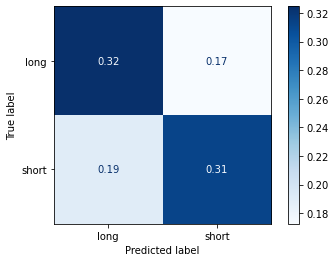

ZScorePredictor
Accuracy:  0.63712
Error Score: 6.436266666666667


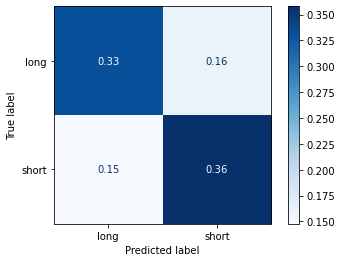

FiveDayPredictor
Accuracy:  0.6912533333333334
Error Score: 8.388666666666667


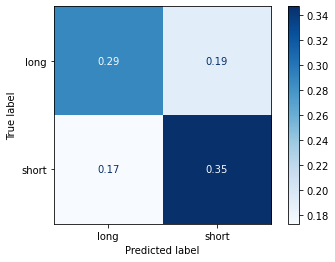

TmmrwUpPredictor
Accuracy:  0.6353866666666667
Error Score: 6.2804
-------------------------------------------


Final Catboost accuracy:  0.6545866666666668
Final Catboost score:  7.035111111111111
Final Feature Importance:                              importance
featureName                            
South America                  0.000000
Oceania                        0.000000
DPRIMElastChangeP              0.000000
East & Central Europe          0.000000
Misery Index                   0.028243
...                                 ...
highVsLowPerc                  4.381288
thisDayAveragePercentChange    4.556486
typPrice                       5.670109
DEXCHUSlastChangeP             5.913813
aroon                         14.605131

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['DPRIMElastChangeP', 'East & Central Europe', 'Oceania', 'South America']
-------------------------------------------


Consumer-Cyclical
droppedColumns: []
valuesToTry: []
droppedColumns: ['BUSL

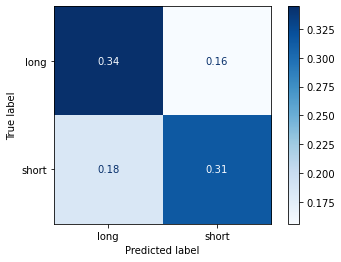

ZScorePredictor
Accuracy:  0.6595466666666666
Error Score: 7.3045333333333335


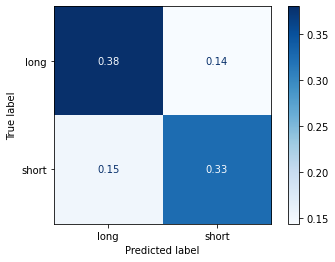

FiveDayPredictor
Accuracy:  0.70496
Error Score: 8.956133333333334


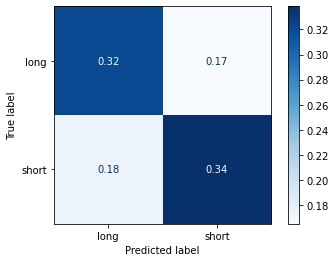

TmmrwUpPredictor
Accuracy:  0.65952
Error Score: 7.2572
-------------------------------------------


Final Catboost accuracy:  0.6746755555555556
Final Catboost score:  7.8392888888888885
Final Feature Importance:                                importance
featureName                              
DPRIMEValue                      0.000000
BUSLOANSValue                    0.000000
CONSUMERValue                    0.000000
DPRIMElastChangeP                0.000000
South America                    0.000000
...                                   ...
NASDAQ100fiveVsTenTickAverage    6.022834
GOLDAMGBD228NLBMlastChangeP      6.077343
typPrice                         6.107253
thisDayPercentChangeStdev        7.125171
aroon                           14.468026

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSValue', 'CONSUMERValue', 'DPRIMEValue', 'DPRIMElastChangeP', 'South America']
-------------------------------------------


Consumer-Defensive
droppedColumns: []
valuesTo

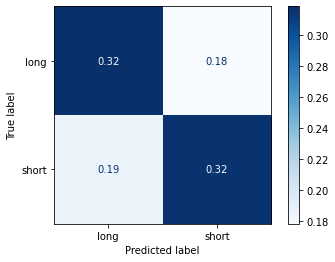

ZScorePredictor
Accuracy:  0.6351733333333334
Error Score: 6.340133333333333


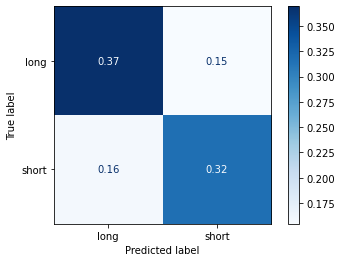

FiveDayPredictor
Accuracy:  0.6864533333333334
Error Score: 8.252933333333333


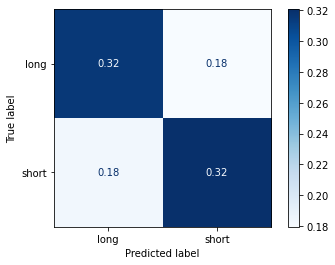

TmmrwUpPredictor
Accuracy:  0.6366666666666667
Error Score: 6.386
-------------------------------------------


Final Catboost accuracy:  0.6527644444444445
Final Catboost score:  6.993022222222222
Final Feature Importance:                                importance
featureName                              
UNRATEValue                      0.000000
DPRIMEValue                      0.000000
CONSUMERValue                    0.000000
DPRIMElastChangeP                0.034589
South America                    0.048317
...                                   ...
DTWEXAFEGSlastChangeP            5.087714
GOLDAMGBD228NLBMlastChangeP      6.407764
NASDAQ100fiveVsTenTickAverage    6.903080
typPrice                         8.643420
aroon                           15.362747

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CONSUMERValue', 'DPRIMEValue', 'UNRATEValue']
-------------------------------------------


Energy
droppedColumns: []
valuesToTry: []
droppedColumns: ['BUSLOANSValue']
v

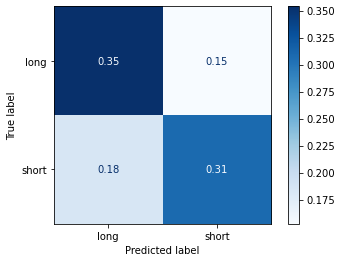

ZScorePredictor
Accuracy:  0.66264
Error Score: 7.429466666666666


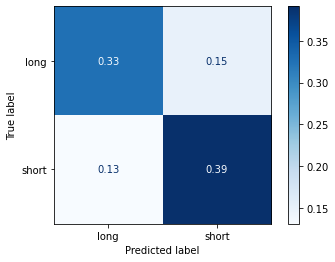

FiveDayPredictor
Accuracy:  0.71752
Error Score: 9.357066666666666


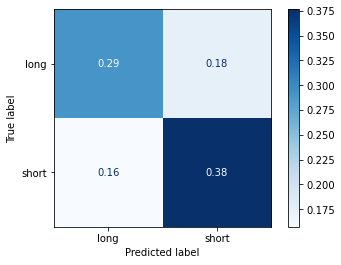

TmmrwUpPredictor
Accuracy:  0.6668533333333333
Error Score: 7.460933333333333
-------------------------------------------


Final Catboost accuracy:  0.6823377777777777
Final Catboost score:  8.082488888888888
Final Feature Importance:                                importance
featureName                              
DPRIMEValue                      0.000000
DPRIMElastChangeP                0.000000
UNRATEValue                      0.000000
CONSUMERValue                    0.000000
CASS-CTLI-Index                  0.000000
...                                   ...
NASDAQ100fiveVsTenTickAverage    5.935730
DEXJPUSlastChangeP               6.794000
DTWEXAFEGSlastChangeP            7.160248
DEXUSUKlastChangeP               7.269405
aroon                           11.485511

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['CASS-CTLI-Index', 'CONSUMERValue', 'DPRIMEValue', 'DPRIMElastChangeP', 'UNRATEValue']
-------------------------------------------


Financial-Services
droppe

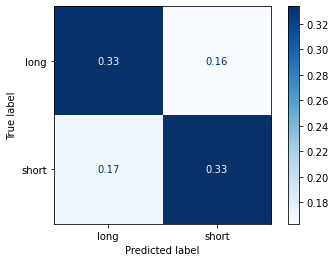

ZScorePredictor
Accuracy:  0.6674666666666667
Error Score: 7.5452


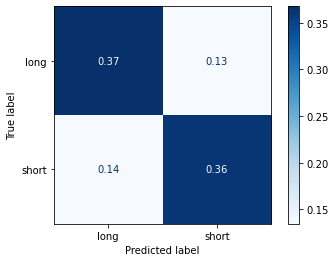

FiveDayPredictor
Accuracy:  0.7297333333333333
Error Score: 9.867866666666666


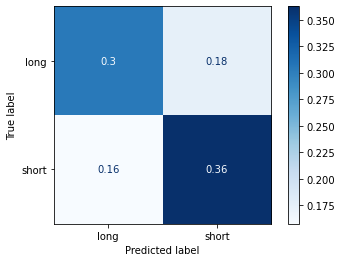

TmmrwUpPredictor
Accuracy:  0.6670133333333333
Error Score: 7.469333333333333
-------------------------------------------


Final Catboost accuracy:  0.6880711111111112
Final Catboost score:  8.294133333333333
Final Feature Importance:                             importance
featureName                           
China (Estimated)             0.000000
Expenditures Index            0.000000
UNRATEfiveVsTenTickAverage    0.000000
CPIAUCSLValue                 0.000000
WPU0911bPercent               0.000000
...                                ...
CCLACBW027SBOGValue           6.624016
ticker                       12.421522
aroon                        13.179424
industry                     13.323141
slowVSFastKAMA               13.654862

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BOPGSTBbPercent', 'BUSLOANSfiveVsTenTickAverage', 'CONSUMERlastChangeP', 'CPIAUCSLValue', 'CPIAUCSLfiveVsTenTickAverage', 'China (Estimated)', 'DPRIMEValue', 'DPRIMElastChangeP', 'Expenditures Ind

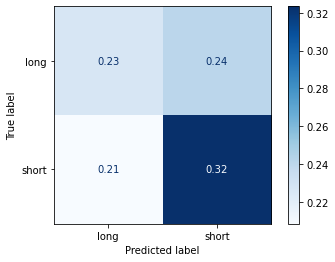

ZScorePredictor
Accuracy:  0.5504225352112676
Error Score: 3.0591549295774647


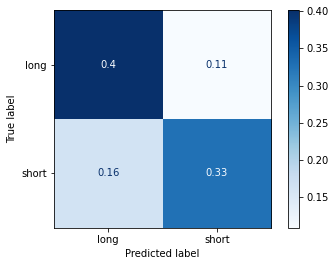

FiveDayPredictor
Accuracy:  0.7284507042253521
Error Score: 9.952112676056338


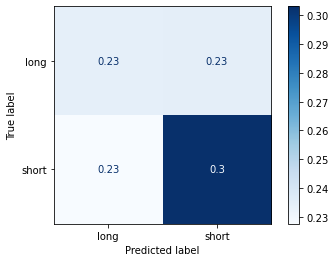

TmmrwUpPredictor
Accuracy:  0.5374647887323943
Error Score: 2.636619718309859
-------------------------------------------


Final Catboost accuracy:  0.6054460093896714
Final Catboost score:  5.215962441314554
Final Feature Importance:                         importance
featureName                       
UNRATEValue               0.000000
DPRIMEValue               0.000000
ticker                    0.000000
industry                  0.000000
SFTPINDM114SFRBSFValue    0.000000
...                            ...
WilliamsR                 5.691048
typPrice                  5.865870
DGS2bPercent              6.080875
STLFSI2lastChangeP        6.339774
aroon                     8.385810

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['DPRIMEValue', 'SFTPINDM114SFRBSFValue', 'TCUfiveVsTenTickAverage', 'UNRATEValue', 'industry', 'ticker']
-------------------------------------------


Healthcare
droppedColumns: []
valuesToTry: []
droppedColumns: ['CONSUMERfiveVsTenTickAverage']
val

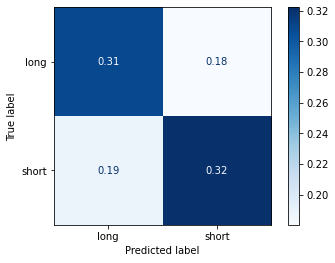

ZScorePredictor
Accuracy:  0.63088
Error Score: 6.1796


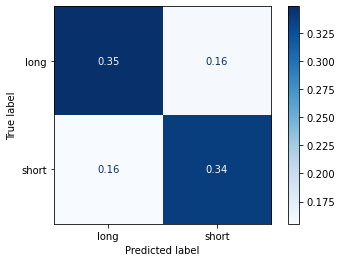

FiveDayPredictor
Accuracy:  0.68768
Error Score: 8.2832


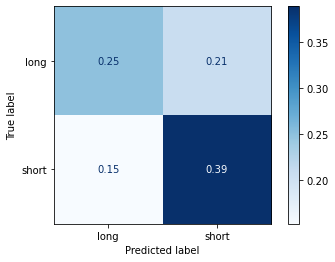

TmmrwUpPredictor
Accuracy:  0.6395466666666667
Error Score: 6.345066666666667
-------------------------------------------


Final Catboost accuracy:  0.6527022222222222
Final Catboost score:  6.935955555555556
Final Feature Importance:                             importance
featureName                           
Expenditures Index            0.000000
DPRIMEValue                   0.000000
DPRIMElastChangeP             0.000000
PCEC96Value                   0.000000
PCEC96fiveVsTenTickAverage    0.000000
...                                ...
highVsLowPerc                 6.017256
DGS30lastChangeP              6.315795
typPrice                      6.507030
ticker                       11.877725
aroon                        20.093991

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['DPRIMEValue', 'DPRIMElastChangeP', 'Expenditures Index', 'PCEC96Value', 'PCEC96fiveVsTenTickAverage']
-------------------------------------------


Industrials
droppedColumns: []
valuesToTry: []
d

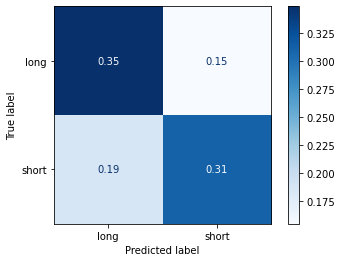

ZScorePredictor
Accuracy:  0.6601866666666667
Error Score: 7.333466666666666


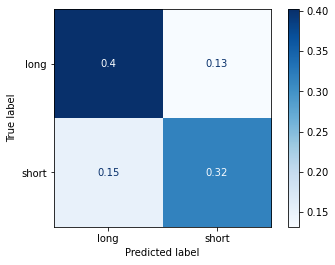

FiveDayPredictor
Accuracy:  0.7178933333333334
Error Score: 9.4692


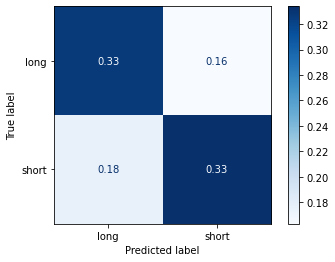

TmmrwUpPredictor
Accuracy:  0.66152
Error Score: 7.337866666666667
-------------------------------------------


Final Catboost accuracy:  0.6798666666666667
Final Catboost score:  8.046844444444444
Final Feature Importance:                              importance
featureName                            
Misery Index                   0.000000
CONSUMERValue                  0.000000
West Europe                    0.000000
WPU0911fiveVsTenTickAverage    0.000000
CASS-CTLI-Index                0.000000
...                                 ...
typPrice                       8.507238
WALCLlastChangeP               9.221953
thisDayPercentChangeStdev     10.470541
DEXUSUKfiveVsTenTickAverage   12.263821
aroon                         12.404599

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSValue', 'CASS-CTLI-Index', 'CONSUMERValue', 'CPIAUCSLbPercent', 'DPRIMEValue', 'DPRIMElastChangeP', 'Misery Index', 'PRS85006092bPercent', 'SFTPINDM114SFRBSFValue', 'UNRATEfiveVsTenTickA

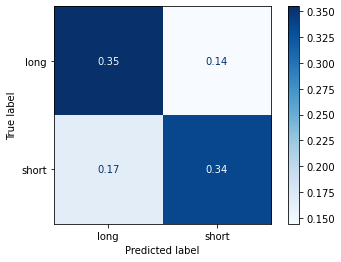

ZScorePredictor
Accuracy:  0.68992
Error Score: 8.4264


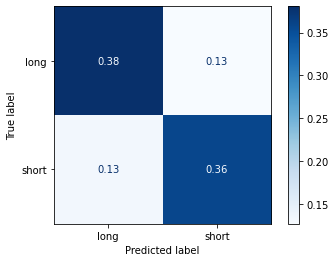

FiveDayPredictor
Accuracy:  0.7391466666666666
Error Score: 10.233866666666666


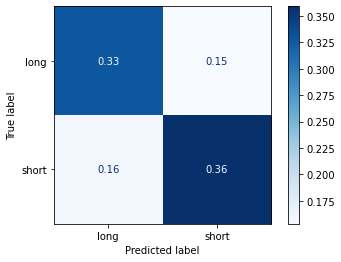

TmmrwUpPredictor
Accuracy:  0.6877066666666667
Error Score: 8.3032
-------------------------------------------


Final Catboost accuracy:  0.7055911111111111
Final Catboost score:  8.987822222222222
Final Feature Importance:                                importance
featureName                              
DPRIMElastChangeP                0.000000
South America                    0.000000
PCEC96Value                      0.000000
BUSLOANSValue                    0.000000
UNRATEValue                      0.000000
...                                   ...
DEXUSUKlastChangeP               5.470655
DEXCHUSlastChangeP               5.877547
NASDAQ100fiveVsTenTickAverage    6.372815
DGS2lastChangeP                  7.122209
aroon                           10.052616

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSValue', 'DPRIMElastChangeP', 'PCEC96Value', 'South America', 'UNRATEValue']
-------------------------------------------


Technology
droppedColumns: []
valuesTo

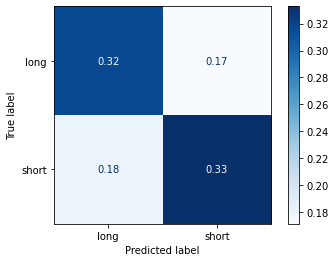

ZScorePredictor
Accuracy:  0.6492
Error Score: 6.8656


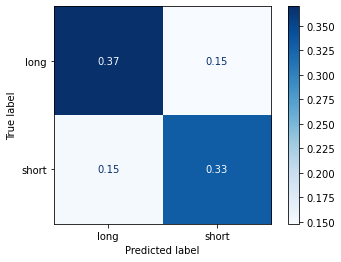

FiveDayPredictor
Accuracy:  0.70096
Error Score: 8.7928


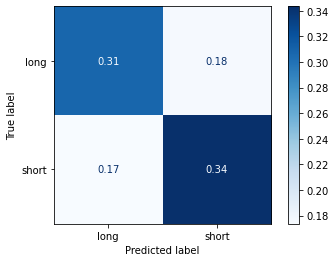

TmmrwUpPredictor
Accuracy:  0.65136
Error Score: 6.922266666666666
-------------------------------------------


Final Catboost accuracy:  0.6671733333333334
Final Catboost score:  7.526888888888888
Final Feature Importance:                              importance
featureName                            
PCEC96Value                    0.000000
BOPGSTBbPercent                0.000000
DPRIMElastChangeP              0.000000
DPRIMEValue                    0.000000
BUSLOANSbPercent               0.000000
...                                 ...
WALCLlastChangeP               7.510113
DEXUSUKfiveVsTenTickAverage    9.076021
typPrice                       9.596430
GOLDAMGBD228NLBMlastChangeP   10.412169
aroon                         16.007353

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BOPGSTBbPercent', 'BUSLOANSbPercent', 'CPIAUCSLValue', 'DPRIMEValue', 'DPRIMElastChangeP', 'PCEC96Value', 'South America', 'UNRATEValue']
-------------------------------------------


Utilities


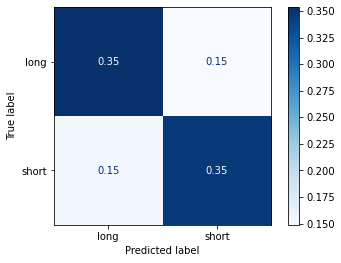

ZScorePredictor
Accuracy:  0.69904
Error Score: 8.722266666666666


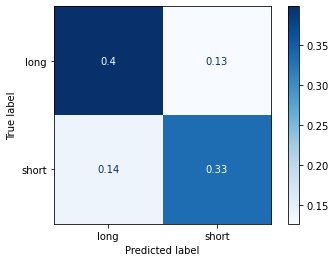

FiveDayPredictor
Accuracy:  0.7325333333333334
Error Score: 10.003333333333334


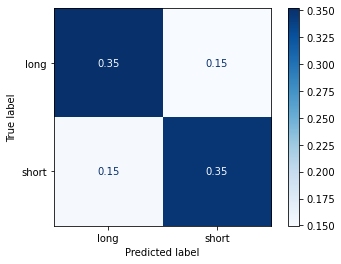

TmmrwUpPredictor
Accuracy:  0.69872
Error Score: 8.7068
-------------------------------------------


Final Catboost accuracy:  0.7100977777777778
Final Catboost score:  9.144133333333334
Final Feature Importance:                                       importance
featureName                                     
DPRIMEValue                             0.000000
CONSUMERValue                           0.000000
UNRATEValue                             0.000000
BUSLOANSValue                           0.000000
NASDAQ100Value                          0.059532
...                                          ...
articleSentChangeSinceYesterday         4.649567
GOLDAMGBD228NLBMfiveVsTenTickAverage    4.651299
GOLDAMGBD228NLBMlastChangeP             5.554398
aroon                                  10.109761
typPrice                               12.064815

[158 rows x 1 columns]
<class 'list'>
Feature to remove:  ['BUSLOANSValue', 'CONSUMERValue', 'DPRIMEValue', 'UNRATEValue']
-------------------------

In [5]:
for file in os.listdir(sectorFolder):
    sector = file.split('.')[0]
    sector = sector.replace(' ', '-')
    print(sector)
    droppedColumns = []
    valuesToTry = []
    seenCol = []
    lastScore = 0
    lastAccuracy = 0
    toContinue = True
    newToRemove = None
    first = True
    oldScore = None
    while (toContinue):
        print('droppedColumns: {}'.format(droppedColumns))
        print('valuesToTry: {}'.format(valuesToTry))
        toRemove, newScore, colCount, _ = buildForest(file, droppedColumns, False)
        for x in toRemove:
            seenCol.append(x)
        if not first:
            print('change in score by removing {} is {}'.format(droppedColumns[-1], newScore - oldScore))
            if newScore <= oldScore :
                droppedColumns.pop()
                if len(valuesToTry) == 0:
                    toContinue  = False
                else:
                    droppedColumns.append(valuesToTry.pop(0))
            else:
                for x in toRemove:
                    if x not in seenCol:
                        valuesToTry.append(x)
                if len(valuesToTry) != 0:
                    droppedColumns.append(valuesToTry.pop(0))
                else:
                    toContinue = False
        else : #if first
            first = False
            valuesToTry = toRemove
            droppedColumns.append(valuesToTry.pop(0))
        oldScore = newScore
    print('Final dropped columns:', droppedColumns)
    verbose = True
    buildForest(file, droppedColumns, True)     
    verbose = False
    print('-------------------------------------------\n\n')

